## Implementation of a graph which represents a map. The user will select the starting point and the destination point

In [2]:
grafo = 'nuevo_graf.txt'

inicio = 'Ribadeo'
destino = 'Verin'

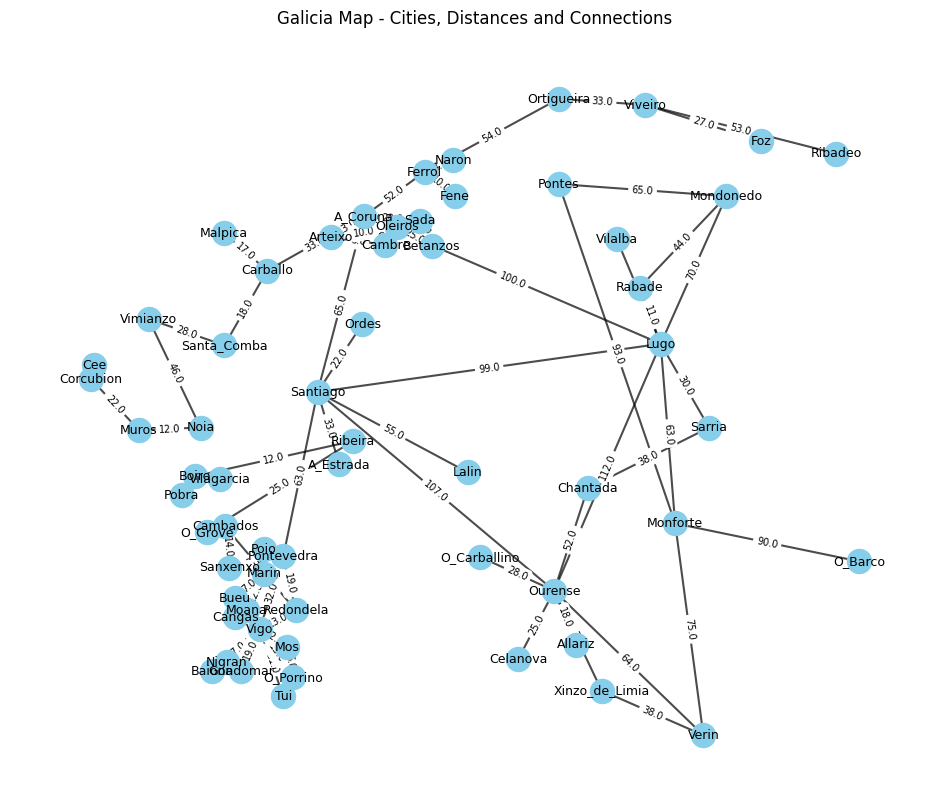

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Cargar datos del archivo
def cargar_mapa(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    nodos = {}
    aristas = []
    leyendo_nodos = False
    leyendo_aristas = False

    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            if "Nodos" in line:
                leyendo_nodos = True
                leyendo_aristas = False
            elif "Aristas" in line:
                leyendo_aristas = True
                leyendo_nodos = False
            continue

        if leyendo_nodos:
            ciudad, lat, lon = line.split(',')
            nodos[ciudad] = (float(lat), float(lon))
        elif leyendo_aristas:
            origen, destino, distancia = line.split(',')
            aristas.append((origen, destino, float(distancia)))  # <-- CAMBIO AQUÍ

    return nodos, aristas

# Crear y visualizar el grafo
def visualizar_mapa(path):
    nodos, aristas = cargar_mapa(path)
    
    G = nx.Graph()

    # Añadir nodos con posición geográfica
    for ciudad, (lat, lon) in nodos.items():
        G.add_node(ciudad, pos=(lon, lat))  # Nota: X = longitud, Y = latitud

    # Añadir aristas con distancia
    for origen, destino, distancia in aristas:
        G.add_edge(origen, destino, weight=distancia)

    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=7)

    plt.title("Galicia Map - Cities, Distances and Connections")
    plt.axis('off')
    plt.show()

# Ruta al archivo de texto
visualizar_mapa(grafo)


In [4]:
import math
import heapq
import time

# Calcular distancia Haversine entre coordenadas
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

# Leer nodos y aristas del archivo
def load_graph(file_path):
    nodes = {}
    graph = {}
    with open(file_path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines) and not lines[i].startswith("# Aristas"):
        if not lines[i].startswith("#") and lines[i].strip():
            city, lat, lon = lines[i].strip().split(",")
            nodes[city] = (float(lat), float(lon))
            graph[city] = {}
        i += 1

    while i < len(lines):
        if not lines[i].startswith("#") and lines[i].strip():
            parts = lines[i].strip().split(",")
            if len(parts) == 3:
                city1, city2, dist = parts
                dist = float(dist)
                graph[city1][city2] = dist
                graph[city2][city1] = dist
        i += 1

    return nodes, graph

# Algoritmo Greedy Best-First Search
def greedy_best_first(graph, nodes, start, goal):
    visited = set()
    queue = []
    heapq.heappush(queue, (haversine(nodes[start], nodes[goal]), 0, start, [start]))

    while queue:
        heuristic_dist, path_dist, current, path = heapq.heappop(queue)

        if current == goal:
            return path, path_dist

        if current in visited:
            continue
        visited.add(current)

        for neighbor in graph[current]:
            if neighbor not in visited:
                new_path = path + [neighbor]
                new_cost = path_dist + graph[current][neighbor]
                heuristic = haversine(nodes[neighbor], nodes[goal])
                heapq.heappush(queue, (heuristic, new_cost, neighbor, new_path))

    return [], float('inf')  # Si no hay camino

# MAIN
if __name__ == "__main__":
    file_path = grafo
    nodes, graph = load_graph(file_path)

    start_city = inicio
    end_city = destino

    if start_city not in nodes or end_city not in nodes:
        print("Ciudad de inicio o fin no válida.")
    else:
        start_time = time.time()
        path, total_dist = greedy_best_first(graph, nodes, start_city, end_city)
        end_time = time.time()

        if path:
            print("Best route found:", " -> ".join(path))
            print(f"Total distance: {total_dist:.2f} km")
        else:
            print("No se encontró un camino.")
        print("Execution time:", round(end_time - start_time, 4), "seconds")



Best route found: Ribadeo -> Viveiro -> Ortigueira -> Ferrol -> A_Coruna -> Lugo -> Ourense -> Verin
Total distance: 468.00 km
Execution time: 0.0001 seconds


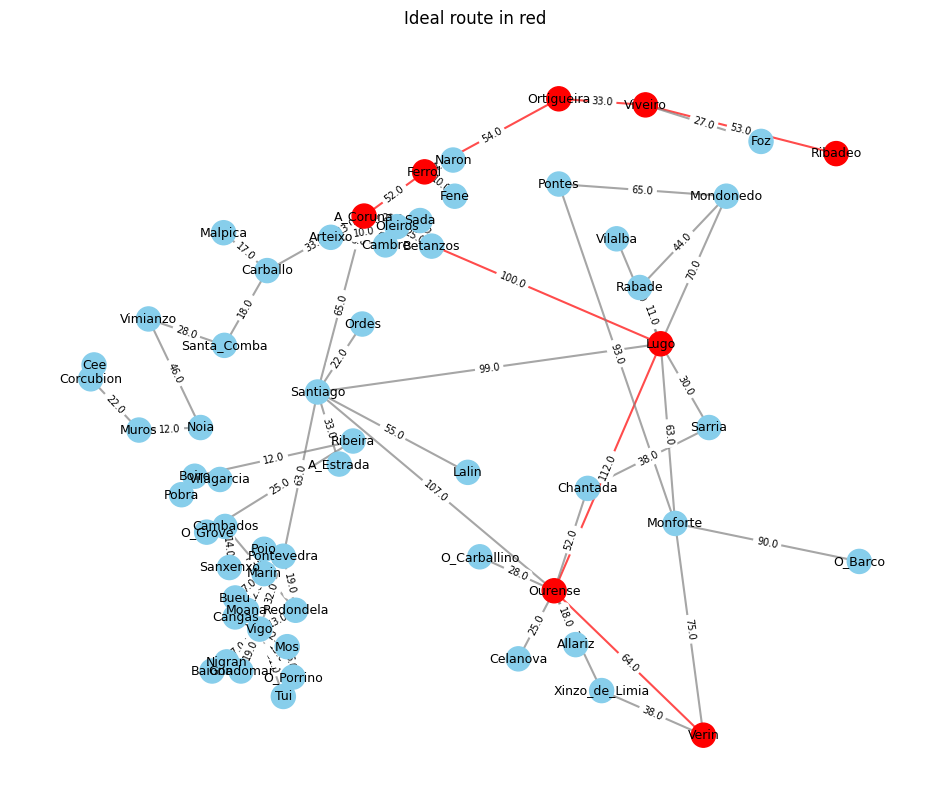

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_ruta(path_archivo, ruta=None):
    nodos, aristas = cargar_mapa(path_archivo)

    G = nx.Graph()

    for ciudad, (lat, lon) in nodos.items():
        G.add_node(ciudad, pos=(lon, lat))

    for origen, destino, distancia in aristas:
        G.add_edge(origen, destino, weight=distancia)

    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_edge_attributes(G, 'weight')

    # Colores de los nodos
    node_colors = []
    for nodo in G.nodes():
        if ruta and nodo in ruta:
            node_colors.append('red')
        else:
            node_colors.append('skyblue')

    # Aristas que están en la ruta (pares consecutivos)
    ruta_edges = []
    if ruta:
        ruta_edges = [(ruta[i], ruta[i+1]) for i in range(len(ruta)-1)]

    # Dibujar nodos y etiquetas
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Dibujar aristas
    edge_colors = []
    for edge in G.edges():
        if edge in ruta_edges or (edge[1], edge[0]) in ruta_edges:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=7)

    plt.title("Ideal route in red")
    plt.axis('off')
    plt.show()

# Ejemplo de uso
visualizar_ruta(grafo, ruta=path)
